In [1]:
# To train the model, I used GPU due to the large size of the training set and the expensive Unet architecture. 
# Running the model on a GPU can significantly reduce training time and improve performance. I have tested the 
# model using TensorFlow-GPU, which can be installed using pip. Once TensorFlow-GPU is installed, you can run 
# the training code on the GPU by using the `tf.device('/GPU:0')` context manager in your code, as described below.

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


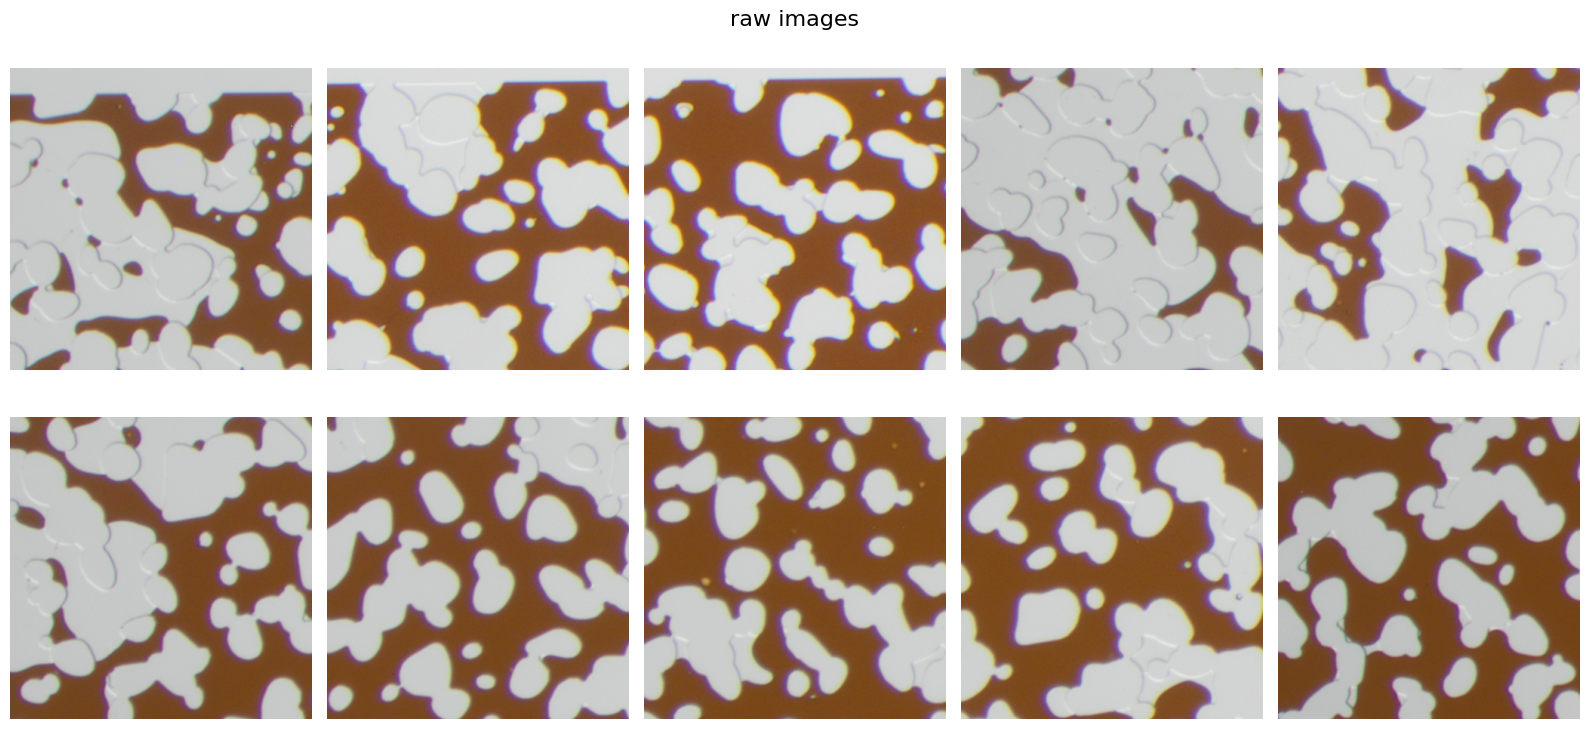

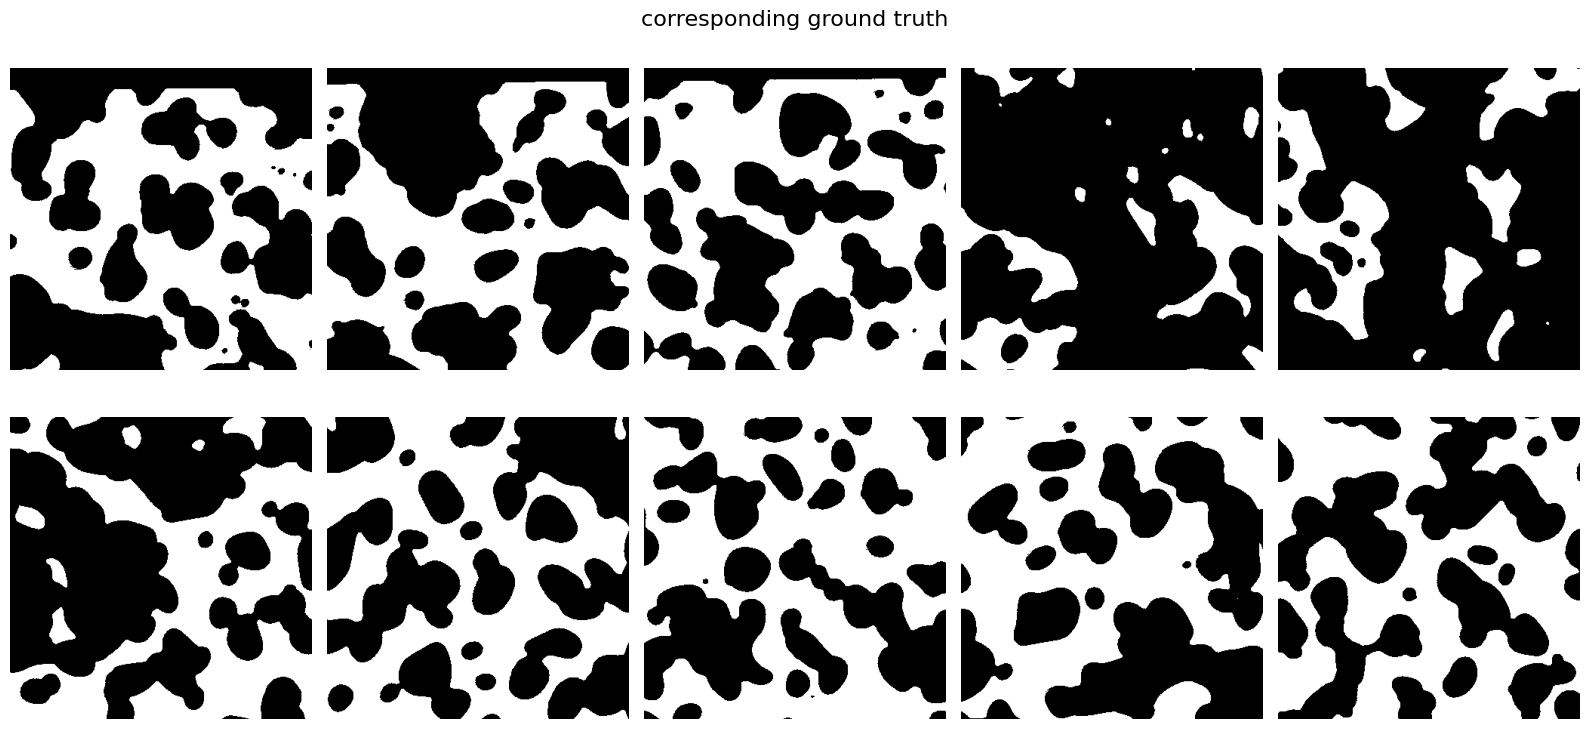

In [2]:
# Data visualization to depict the original (raw) images along with the corresponding 
# masks generated through the online annotation platform, www.apeer.com

import matplotlib.pyplot as plt
import numpy as np
import cv2 
import glob
SIZE = 400

image_list = [] 
path_to_images = "C:/Users/dania/Desktop/unet_microfluidic/test_49_ASP/original_tile_training_for_plot/*.*"
for one_img in glob.glob (path_to_images):
    img = cv2.imread(one_img, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image_list.append(img)
    
mask_ground_truth_list = [] 
path_to_mask_ground_truth = "C:/Users/dania/Desktop/unet_microfluidic/test_49_ASP/mask_tile_training_for_plot/*.*"
for one_img in glob.glob (path_to_mask_ground_truth):
    img = cv2.imread(one_img, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask_ground_truth_list.append(img)


def tile_plotter(image_list, title): 
    fig, axs = plt.subplots(2, 5, figsize=(16, 8))
    for i, ax in enumerate(axs.flat):
        if i < len(image_list):
            ax.imshow(image_list[i])
        ax.axis('off')
    plt.subplots_adjust(hspace=0.05)
    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.show()

    
tile_plotter (image_list, 'raw images')
tile_plotter (mask_ground_truth_list, 'corresponding ground truth')

In [5]:
# Data handling and making them ready to be fed into the deep learning model 

import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
#import tensorflow as tf
from datetime import datetime 
import cv2
from PIL import Image
import glob 


image_directory = "C:/Users/dania/Desktop/unet_microfluidic/test_49_ASP/original_tile_training/"
mask_directory = "C:/Users/dania/Desktop/unet_microfluidic/test_49_ASP/mask_tile_training/"

SIZE= 400

image_dataset = []  
mask_dataset = [] 

images = os.listdir(image_directory) 
for i, image_name in enumerate(images):   
    #print (image_name)#.split('.')[1]) 
    image = cv2.imread(image_directory+image_name)
    image = Image.fromarray(image) 
    image = image.resize((SIZE, SIZE)) 
    image_dataset.append(np.array(image))

    
masks = os.listdir(mask_directory)
for i, image_name in enumerate(masks):
    image = cv2.imread(mask_directory+image_name,  0)
    image = Image.fromarray(image)
    image = image.resize((SIZE, SIZE))
    mask_dataset.append(np.array(image))


image_dataset = np.array(image_dataset)
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

In [32]:
# Unet model architecture details
from keras_unet_collection import models, losses

num_labels = 1  # Binary classification 
input_shape = (400, 400, 3) 
batch_size = 2

# Unet with ImageNet as weights and with VGG16 backbone
help(models.unet_2d)

model_Unet = models.unet_2d((input_shape), filter_num=[64, 128],
                           n_labels=num_labels, 
                           stack_num_down=2, stack_num_up=2, 
                           activation='ReLU', 
                           output_activation='Sigmoid', 
                           batch_norm=True, pool=False, unpool=False, 
                           backbone='VGG16', weights='imagenet', 
                           freeze_backbone=True, freeze_batch_norm=True, 
                           name='unet')


model_Unet.compile(loss='binary_crossentropy', optimizer=Adam(lr = 1e-3), 
              metrics=['accuracy', losses.dice_coef])

print(model_Unet.summary())

Help on function unet_2d in module keras_unet_collection._model_unet_2d:

unet_2d(input_size, filter_num, n_labels, stack_num_down=2, stack_num_up=2, activation='ReLU', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='unet')
    U-net with an optional ImageNet-trained bakcbone.
    
    unet_2d(input_size, filter_num, n_labels, stack_num_down=2, stack_num_up=2,
            activation='ReLU', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, 
            backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='unet')
    
    ----------
    Ronneberger, O., Fischer, P. and Brox, T., 2015, October. U-net: Convolutional networks for biomedical image segmentation. 
    In International Conference on Medical image computing and computer-assisted intervention (pp. 234-241). Springer, Cham.
    
    Input
    ----------
        input_s

                                                                                                  
 unet_output (Conv2D)           (None, 400, 400, 1)  65          ['unet_up0_conv_after_concat_1_ac
                                                                 tivation[0][0]']                 
                                                                                                  
 unet_output_activation (Activa  (None, 400, 400, 1)  0          ['unet_output[0][0]']            
 tion)                                                                                            
                                                                                                  
Total params: 482,497
Trainable params: 221,825
Non-trainable params: 260,672
__________________________________________________________________________________________________
None


In [7]:
# Training model using GPU 
with tf.device('/GPU:0'):
    Unet_history = model_Unet.fit(image_dataset, mask_dataset, 
                                  verbose=1,
                                  batch_size=batch_size,
                                  shuffle=False,
                                  epochs=100)


Epoch 1/100
50/50 [==============================] - 15s 182ms/step - loss: 0.1049 - accuracy: 0.9644 - dice_coef: 0.8760
Epoch 2/100
50/50 [==============================] - 9s 183ms/step - loss: 0.0550 - accuracy: 0.9839 - dice_coef: 0.9248
Epoch 3/100
50/50 [==============================] - 9s 183ms/step - loss: 0.0433 - accuracy: 0.9863 - dice_coef: 0.9409
Epoch 4/100
50/50 [==============================] - 9s 184ms/step - loss: 0.0366 - accuracy: 0.9877 - dice_coef: 0.9510
Epoch 5/100
50/50 [==============================] - 9s 185ms/step - loss: 0.0323 - accuracy: 0.9886 - dice_coef: 0.9577
Epoch 6/100
50/50 [==============================] - 9s 185ms/step - loss: 0.0299 - accuracy: 0.9890 - dice_coef: 0.9616
Epoch 7/100
50/50 [==============================] - 9s 185ms/step - loss: 0.0285 - accuracy: 0.9891 - dice_coef: 0.9641
Epoch 8/100
50/50 [==============================] - 9s 186ms/step - loss: 0.0268 - accuracy: 0.9896 - dice_coef: 0.9666
Epoch 9/100
50/50 [============

50/50 [==============================] - 9s 187ms/step - loss: 0.0167 - accuracy: 0.9928 - dice_coef: 0.9807
Epoch 69/100
50/50 [==============================] - 9s 188ms/step - loss: 0.0170 - accuracy: 0.9927 - dice_coef: 0.9804
Epoch 70/100
50/50 [==============================] - 9s 187ms/step - loss: 0.0173 - accuracy: 0.9925 - dice_coef: 0.9800
Epoch 71/100
50/50 [==============================] - 9s 187ms/step - loss: 0.0168 - accuracy: 0.9928 - dice_coef: 0.9806
Epoch 72/100
50/50 [==============================] - 9s 187ms/step - loss: 0.0167 - accuracy: 0.9928 - dice_coef: 0.9807
Epoch 73/100
50/50 [==============================] - 9s 187ms/step - loss: 0.0169 - accuracy: 0.9927 - dice_coef: 0.9805
Epoch 74/100
50/50 [==============================] - 9s 187ms/step - loss: 0.0170 - accuracy: 0.9926 - dice_coef: 0.9804
Epoch 75/100
50/50 [==============================] - 9s 188ms/step - loss: 0.0168 - accuracy: 0.9928 - dice_coef: 0.9806
Epoch 76/100
50/50 [=================

In [8]:
# saving the model
model_Unet.save('unet_100_epochs.hdf5')


In [ ]:
# loading the saved model
# from keras.models import load_model
# filename = "C:/Users/dania/Desktop/unet_microfluidic/unet.hdf5"
# model_loaded = load_model(filename, compile=False)


In [9]:
# Making predictions using the trained model

path_to_test_images = "C:/Users/dania/Desktop/unet_microfluidic/test_49_ASP/original_tile_testing/*.*"

path_to_segmented_images = "C:/Users/dania/Desktop/unet_microfluidic/test_49_ASP/unet_results_100_epochs/"


test_dataset = [] 
prediction_set = [] 

model = model_Unet

for test_img_name in glob.glob (path_to_test_images):
    #print (test_img_name.split('\\') [-1]) 
    test_img = cv2.imread(test_img_name, 1)        
    test_img = cv2.resize(test_img, (SIZE, SIZE))
    test_dataset.append(test_img)
    test_img_gray = np.expand_dims(test_img, 0)

    prediction = (model.predict(test_img_gray)[0,:,:,0] > 0.5).astype(np.uint8) 
 
    prediction_image = prediction.reshape((SIZE, SIZE))
    prediction_set.append(prediction_image)
    plt.imsave(path_to_segmented_images + test_img_name.split('\\') [-1], prediction_image, cmap='gray')



1/1 [==============================] - 0s 19ms/step


In [34]:
ground_truth_test_set = [] 
path_to_ground_truth_test_set = "C:/Users/dania/Desktop/unet_microfluidic/test_49_ASP/mask_tile_testing/*.*"
for ground_truth in glob.glob (path_to_ground_truth_test_set):
    img = cv2.imread(ground_truth, 0)
    img = cv2.resize(img, (SIZE, SIZE))
    img = img / 255.
    ground_truth_test_set.append(img)

(400, 400, 3)


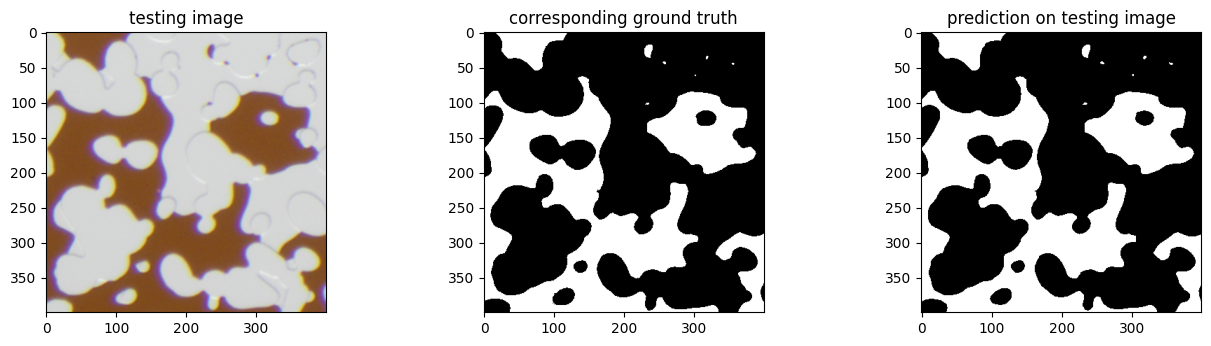

In [57]:
import random
#random.seed(42) # set random seed

test_img_number = random.randint(0, len(test_dataset))  

test_img = test_dataset[test_img_number] 
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
ground_truth=ground_truth_test_set[test_img_number]
prediction = prediction_set[test_img_number]

print (test_img.shape)
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('testing image')
plt.imshow(test_img)

plt.subplot(232)
plt.title('corresponding ground truth')
plt.imshow(ground_truth, cmap='gray')
plt.subplot(233)
plt.title('prediction on testing image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [58]:
 # IoU calc.
    
from keras.metrics import MeanIoU
mean_IoU_list = []
num_classes = 2 # 1 for background (unlabelled with 0 values) one for oil  

for i in range(len(ground_truth_test_set)):
    IOU_keras = MeanIoU(num_classes=num_classes)  
    IOU_keras.update_state(ground_truth_set[i], prediction_set[i])
    mean_IoU_list.append(IOU_keras.result().numpy()*100)


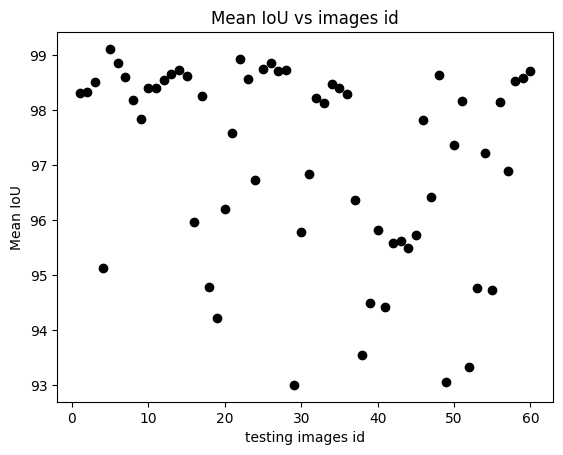

In [62]:
x = range(1, len(mean_IoU_list)+1)

plt.plot(x, mean_IoU_list, 'o', color = 'black')
plt.xlabel('testing images id')
plt.ylabel('Mean IoU')
plt.title('Mean IoU vs images id')
plt.show()